In [9]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import kagglehub # Se requiere para la descarga del dataset

try:
    path = kagglehub.dataset_download("alessiocorrado99/animals10")

    data_dir = str(path) + "/raw-img"
    print(f"Dataset 'Animals10' descargado en: {data_dir}")
except Exception as e:
    print(f"Error al descargar desde Kaggle Hub. Asegúrate de tener las credenciales configuradas. {e}")
    data_dir = "./raw-img" 

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Estandarizar el tamaño de las imágenes (ej: a 64x64)
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)


total_size = len(full_dataset)
test_size = int(0.10 * total_size)
train_val_size = total_size - test_size
val_size = int(0.10 * train_val_size) # 10% del conjunto restante (aprox 9% del total)
train_size = train_val_size - val_size

train_val_data, test_data = torch.utils.data.random_split(full_dataset, [train_val_size, test_size])
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])

print(f"Tamaño de Entrenamiento: {len(train_data)}")
print(f"Tamaño de Validación: {len(val_data)}")
print(f"Tamaño de Prueba: {len(test_data)}")

batch_size_setting = 64 

train_loader = DataLoader(train_data, batch_size=batch_size_setting, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size_setting, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size_setting, shuffle=False)

100%|██████████| 586M/586M [01:20<00:00, 7.66MB/s] 

Extracting files...


Dataset 'Animals10' descargado en: C:\Users\agust\.cache\kagglehub\datasets\alessiocorrado99\animals10\versions\2/raw-img
Tamaño de Entrenamiento: 21206
Tamaño de Validación: 2356
Tamaño de Prueba: 2617


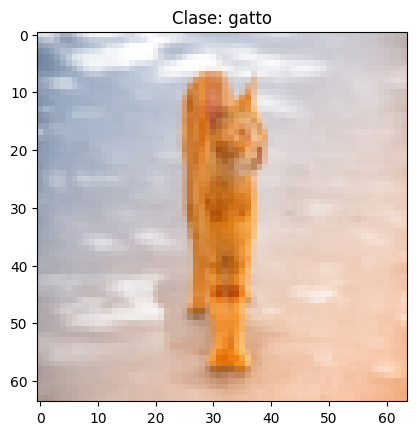

In [12]:
import matplotlib.pyplot as plt
import numpy as np

dataiter = iter(train_loader)
images, labels = next(dataiter)

image = images[0] 

image_np = image.numpy().transpose((1, 2, 0))
image_np = (image_np * 0.5) + 0.5 
image_np = np.clip(image_np, 0, 1) # Asegurar que los valores estén entre 0 y 1

plt.imshow(image_np)
plt.title(f'Clase: {full_dataset.classes[labels[0]]}') # Mostrar el nombre de la clase
plt.show()

In [13]:
class AnimalNet(nn.Module):
    def __init__(self):
        super(AnimalNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0) # Salida: (N, 16, 32, 32)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(32 * 16 * 16, 120)
        
    
        self.dropout = nn.Dropout(p=0.5) 
        self.fc2 = nn.Linear(120, 10) 

    def forward(self, x):
        # Primera capa CONV -> RELU -> POOL
        x = self.pool(F.relu(self.conv1(x))) # (N, 3, 64, 64) -> (N, 16, 32, 32)
        
        # Segunda capa CONV -> RELU -> POOL
        x = self.pool(F.relu(self.conv2(x))) # (N, 16, 32, 32) -> (N, 32, 16, 16)

        # Aplanar imagen
        x = x.view(-1, 32 * 16 * 16) 

        # Capa FC1 -> RELU
        x = F.relu(self.fc1(x))
        
        # Aplicar Dropout
        x = self.dropout(x)
        
        # Capa FC2 (Salida)
        x = self.fc2(x)
        return x

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = AnimalNet().to(device) # <--- Cambiado de MNISTNet a AnimalNet

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01) # Recuerda que 'lr' es un hiperparámetro a optimizar [cite: 28]

In [15]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        """
        Inicializa el Early Stopper.
        :param patience: Número de épocas a esperar después de que no haya mejora.
        :param min_delta: Cambio mínimo para ser considerado una mejora.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        """
        Verifica si se debe detener el entrenamiento.
        :param validation_loss: Pérdida actual en el conjunto de validación.
        :return: True si se debe detener, False en caso contrario.
        """
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0  # Reiniciar el contador si hay mejora
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
        
early_stopper = EarlyStopper(patience=5, min_delta=0.001)

num_epochs = 50 # Aumentamos las épocas, ya que el Early Stopping las limitará si es necesario
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []} # Para guardar métricas

print(f"Comenzando el entrenamiento en {device}...")

for epoch in range(num_epochs):
    
    net.train() # Poner el modelo en modo entrenamiento (ej. para Dropout)
    epoch_train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad() # Limpiar los gradientes

        output = net(images)
        
        # Calcular la pérdida
        loss = loss_fn(output, labels)
        
        # Retropropagación y Actualización de pesos
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)

    net.eval() # Poner el modelo en modo evaluación (desactiva Dropout)
    epoch_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # Desactivar el cálculo de gradientes para ahorrar memoria y tiempo
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = net(images)
            loss = loss_fn(output, labels)
            
            epoch_val_loss += loss.item()

            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    if early_stopper.early_stop(avg_val_loss):
        print(f"Parada anticipada en la Época {epoch+1}. Sin mejora durante {early_stopper.patience} épocas.")
        break

Comenzando el entrenamiento en cuda...
Epoch 1/50, Train Loss: 2.2008, Val Loss: 2.1248, Val Acc: 25.34%
Epoch 2/50, Train Loss: 2.0652, Val Loss: 1.9636, Val Acc: 30.09%
Epoch 3/50, Train Loss: 1.9551, Val Loss: 1.8437, Val Acc: 35.31%
Epoch 4/50, Train Loss: 1.8896, Val Loss: 1.8279, Val Acc: 35.23%
Epoch 5/50, Train Loss: 1.8389, Val Loss: 1.7645, Val Acc: 38.58%
Epoch 6/50, Train Loss: 1.7970, Val Loss: 1.7171, Val Acc: 39.94%
Epoch 7/50, Train Loss: 1.7516, Val Loss: 1.7962, Val Acc: 34.34%
Epoch 8/50, Train Loss: 1.7092, Val Loss: 1.6784, Val Acc: 40.92%
Epoch 9/50, Train Loss: 1.6793, Val Loss: 1.6004, Val Acc: 44.99%
Epoch 10/50, Train Loss: 1.6363, Val Loss: 1.5857, Val Acc: 45.46%
Epoch 11/50, Train Loss: 1.5949, Val Loss: 1.5662, Val Acc: 45.67%
Epoch 12/50, Train Loss: 1.5576, Val Loss: 1.5254, Val Acc: 48.81%
Epoch 13/50, Train Loss: 1.5227, Val Loss: 1.4850, Val Acc: 48.51%
Epoch 14/50, Train Loss: 1.4814, Val Loss: 1.4353, Val Acc: 50.38%
Epoch 15/50, Train Loss: 1.4470,

In [16]:
net.eval() # Asegurar que el modelo esté en modo evaluación
correct = 0
total = 0
with torch.no_grad():
  for images, labels in test_loader: # Usar el test_loader
    images, labels = images.to(device), labels.to(device)
    total += labels.size(0)

    output = net(images)
    _, predicted = torch.max(output.data, 1)

    correct += (predicted == labels).sum().item()

final_accuracy = 100 * correct / total
print(f'Accuracy Final en Test: {final_accuracy:.2f}%')

Accuracy Final en Test: 53.95%
